<center><i>Łukasz Staniszewski, Łukasz Topolski</i></center>
<h1><center>Mini projekt 2 - SSNE</center></h1>

## Polecenie

+ Załóżmy że kilka lat temu w konkursie wygraliśmy 5 Bitcoinów, które możemy aktualnie wymienić na 300 000 dolarów. Pieniądze te chcielibyśmy przeznaczyć na zakup mieszkania, ale potrzebujemy metody która dla niepełnych ogłoszeń pomoże nam określić czy dana nieruchomość jest w ogóle w naszym zasięgu. Z pomocą przychodzą nam historyczne dane sprzedażowe.
+ W oparciu o dostępne atrybuty zbuduj model który pomoże oszacować czy dana nieruchomość kosztuje więcej, czy mniej niż 300 000. Do dyspozycji mają Państwo dane treningowe (train_data.csv) z oryginalnymi cenami nieruchomości (SalePrice), oraz tak jak ostatnio zbiór testowy (test_data.csv).
+ Jako że zadanie jest do zrobienia w domu, proszę przygotować kod który pozwoli na uzyskanie DOKŁADNIE tych samych predykcji które zostały dołączone. W tym celu proszę zadbać o odpowiednie seedy losowych modułów, itp..
+ W ramach predykcji proszę zapisać tym razem dwie kolumny:
    + pierwszą - ciągłą, którą będzie przewidywanie, czasami błędnie nazywane prawdopodobieństwem, tego że dana nieruchomość ze zbioru test_data jest warta więcej niż 300 000. Wartości te mogą być w dowolnych przedziałach <0,1>, (-inf, +inf) lub dowolne podzbiory.
    + drugą - binarną (o wartościach 0 i 1), w której sami ustalą Państwo odpowiedni punkt odcięcia i zdecydują które przykłady przewidywać jako 0, a które jako 1. Przyjmijmy że klasa 1 oznacza że nieruchomość jest warta powyżej 300 000.
+ Końcowe wyniki obliczane będą w oparciu o accuracy dla binarnych wartości oraz powierzchnię pod krzywą ROC dla ciągłych przewidywań:
    + (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)


## Biblioteki + seed:

In [1]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import numpy as np
import pandas as pd
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn import preprocessing

+ Seed:

In [2]:
device = torch.device("cuda")
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(500)
    torch.cuda.manual_seed_all(500)
torch.manual_seed(500)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
device

device(type='cuda')

+ Wyrzucenie warningów:

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Przygotowanie danych:

In [4]:
estate_data_train_orig = pd.read_csv("data/train_data.csv")
estate_data_eval_orig = pd.read_csv("data/test_data.csv")
estate_data_train = estate_data_train_orig.copy()
estate_data_eval = estate_data_eval_orig.copy()
pd.set_option("display.max_columns", None)

In [5]:
estate_data_train

,SalePrice,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_APT,N_manager,N_elevators,SubwayStation,N_FacilitiesNearBy(PublicOffice),N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,51327,1985,2007,8,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,1.0,2.0,2.0,Daegu,5.0,1,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,3,12.0,4.0
1,48672,1985,2007,8,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,1.0,2.0,2.0,Daegu,5.0,1,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,3,12.0,4.0
2,380530,2006,2007,8,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,6.0,5.0,11.0,Sin-nam,1.0,1,0.0,1.0,0.0,0.0,2.0,2.0,1.0,2.0,5,3.0,7.0
3,221238,1993,2007,8,1761,3,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,8.0,20.0,Myung-duk,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
4,35840,1992,2007,8,355,5,corridor,individual_heating,management_in_trust,200.0,0.0,5min~10min,10min~15min,3.0,5.0,10.0,Myung-duk,7.0,1,1.0,1.0,5.0,1.0,4.0,3.0,5.0,5.0,3,16.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,511504,2007,2017,8,1643,19,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,7.0,14.0,16.0,Kyungbuk_uni_hospital,3.0,1,2.0,1.0,0.0,2.0,3.0,3.0,2.0,2.0,10,9.0,10.0
4120,298230,2006,2017,8,903,13,terraced,individual_heating,management_in_trust,123.0,181.0,5min~10min,0-5min,3.0,3.0,11.0,Myung-duk,3.0,1,1.0,1.0,2.0,0.0,4.0,3.0,3.0,1.0,4,8.0,11.0
4121,357522,2007,2017,8,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,7.0,14.0,16.0,Kyungbuk_uni_hospital,3.0,1,2.0,1.0,0.0,2.0,3.0,3.0,2.0,2.0,10,9.0,10.0
4122,312389,1978,2017,8,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,2.0,1.0,4.0,Kyungbuk_uni_hospital,3.0,2,1.0,1.0,0.0,0.0,3.0,3.0,3.0,2.0,3,7.0,11.0


In [6]:
estate_data_eval

,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_APT,N_manager,N_elevators,SubwayStation,N_FacilitiesNearBy(PublicOffice),N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,1993,2008,5,914,14,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,8.0,20.0,Myung-duk,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
1,1993,2014,3,914,20,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,8.0,20.0,Myung-duk,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
2,2013,2016,1,644,13,terraced,individual_heating,management_in_trust,8.0,930.0,0~5min,0-5min,7.0,6.0,14.0,Kyungbuk_uni_hospital,5.0,1,1.0,1.0,0.0,1.0,4.0,2.0,2.0,3.0,7,9.0,11.0
3,2009,2017,6,910,6,terraced,individual_heating,management_in_trust,25.0,203.0,0~5min,no_bus_stop_nearby,1.0,2.0,5.0,no_subway_nearby,2.0,1,0.0,0.0,2.0,1.0,2.0,1.0,1.0,1.0,5,6.0,5.0
4,1993,2013,12,1451,14,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,8.0,20.0,Myung-duk,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,2008,2014,12,829,20,terraced,individual_heating,management_in_trust,197.0,475.0,5min~10min,0-5min,6.0,6.0,14.0,Sin-nam,3.0,1,1.0,1.0,0.0,1.0,2.0,3.0,2.0,2.0,8,7.0,9.0
1763,1993,2013,7,914,19,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,8.0,20.0,Myung-duk,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
1764,2007,2010,11,868,21,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,7.0,14.0,16.0,Kyungbuk_uni_hospital,3.0,1,2.0,1.0,0.0,2.0,3.0,3.0,2.0,2.0,10,9.0,10.0
1765,2006,2014,12,1743,10,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,6.0,5.0,11.0,Sin-nam,1.0,1,0.0,1.0,0.0,0.0,2.0,2.0,1.0,2.0,5,3.0,7.0


In [7]:
estate_data_train.dtypes

SalePrice                               int64
YearBuilt                               int64
YrSold                                  int64
MonthSold                               int64
Size(sqf)                               int64
Floor                                   int64
HallwayType                            object
HeatingType                            object
AptManageType                          object
N_Parkinglot(Ground)                  float64
N_Parkinglot(Basement)                float64
TimeToBusStop                          object
TimeToSubway                           object
N_APT                                 float64
N_manager                             float64
N_elevators                           float64
SubwayStation                          object
N_FacilitiesNearBy(PublicOffice)      float64
N_FacilitiesNearBy(Hospital)            int64
N_FacilitiesNearBy(Dpartmentstore)    float64
N_FacilitiesNearBy(Mall)              float64
N_FacilitiesNearBy(ETC)           

In [8]:
estate_data_train.describe()

,SalePrice,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_APT,N_manager,N_elevators,N_FacilitiesNearBy(PublicOffice),N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
count,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000
mean,221564.653249,2002.907129,2012.684772,6.201261,960.484239,11.994908,195.616392,572.357905,5.607177,6.333172,11.151552,4.141125,1.298982,0.912464,0.947381,1.932590,0.658341,3.018914,2.425800,2.663191,2.753637,5.801164,9.890883,10.861542
std,106676.053778,8.825764,2.917335,3.398540,386.804458,7.548805,218.919683,409.246602,2.818877,3.193502,7.810642,1.775126,0.478587,0.814821,0.396927,2.199886,0.661033,0.940444,1.032846,1.547938,1.491970,2.340055,3.403815,4.417403
min,34070.000000,1978.000000,2007.000000,1.000000,135.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,144247.000000,1993.000000,2010.000000,3.000000,644.000000,6.000000,11.000000,184.000000,3.000000,5.000000,5.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,4.000000,8.000000,7.000000
50%,207964.000000,2006.000000,2013.000000,6.000000,910.000000,11.000000,100.000000,536.000000,7.000000,6.000000,11.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,2.000000,2.000000,5.000000,9.000000,10.000000
75%,289380.000000,2007.000000,2015.000000,9.000000,1160.000000,17.000000,249.000000,798.000000,8.000000,8.000000,16.000000,5.000000,2.000000,2.000000,1.000000,5.000000,1.000000,4.000000,3.000000,4.000000,4.000000,7.000000,13.000000,15.000000
max,585840.000000,2015.000000,2017.000000,12.000000,2337.000000,43.000000,713.000000,1321.000000,13.000000,14.000000,27.000000,7.000000,2.000000,2.000000,2.000000,5.000000,2.000000,6.000000,4.000000,5.000000,5.000000,10.000000,16.000000,17.000000


+ Wydzielmy targets:

In [9]:
estate_data_train.SalePrice = (estate_data_train.SalePrice > 300000).astype(int)
target_estate_data = estate_data_train["SalePrice"]
estate_data_train.drop(columns="SalePrice", inplace=True)

+ Zamienmy binarne na 0/1: 

In [10]:
categorical_columns = ["HallwayType","HeatingType","AptManageType","TimeToBusStop","TimeToSubway","SubwayStation"]
for col_name in categorical_columns:
    print(f"{col_name} uniques: {estate_data_train[col_name].unique()}")

HallwayType uniques: ['corridor' 'terraced' 'mixed']
HeatingType uniques: ['individual_heating' 'central_heating']
AptManageType uniques: ['self_management' 'management_in_trust']
TimeToBusStop uniques: ['0~5min' '5min~10min' '10min~15min']
TimeToSubway uniques: ['5min~10min' '0-5min' '15min~20min' '10min~15min' 'no_bus_stop_nearby']
SubwayStation uniques: ['Daegu' 'Sin-nam' 'Myung-duk' 'Kyungbuk_uni_hospital' 'Chil-sung-market'
 'Bangoge' 'Banwoldang' 'no_subway_nearby']


In [11]:
estate_data_train.HeatingType = (estate_data_train.HeatingType=='individual_heating').astype(int)
estate_data_train.AptManageType = (estate_data_train.AptManageType=='self_management').astype(int)
estate_data_eval.HeatingType = (estate_data_train.HeatingType=='individual_heating').astype(int)
estate_data_eval.AptManageType = (estate_data_train.AptManageType=='self_management').astype(int)

+ Zamieniamy porzadkowe na liczby:

In [12]:
import re
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [13]:
def classify_columns(col_name, df):
    temp_col = df[col_name].unique()
    temp_col = temp_col.tolist()
    temp_col.sort(key=natural_keys)
    for i in range(len(temp_col)):
        df[col_name].replace(temp_col[i], i, inplace=True)

In [14]:
classify_columns('TimeToSubway', estate_data_train)
classify_columns('TimeToBusStop', estate_data_train)
estate_data_train

,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_APT,N_manager,N_elevators,SubwayStation,N_FacilitiesNearBy(PublicOffice),N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,1985,2007,8,587,8,corridor,1,1,80.0,76.0,0,1,1.0,2.0,2.0,Daegu,5.0,1,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,3,12.0,4.0
1,1985,2007,8,587,6,corridor,1,1,80.0,76.0,0,1,1.0,2.0,2.0,Daegu,5.0,1,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,3,12.0,4.0
2,2006,2007,8,2056,8,terraced,1,0,249.0,536.0,0,0,6.0,5.0,11.0,Sin-nam,1.0,1,0.0,1.0,0.0,0.0,2.0,2.0,1.0,2.0,5,3.0,7.0
3,1993,2007,8,1761,3,mixed,1,0,523.0,536.0,0,3,8.0,8.0,20.0,Myung-duk,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
4,1992,2007,8,355,5,corridor,1,0,200.0,0.0,1,2,3.0,5.0,10.0,Myung-duk,7.0,1,1.0,1.0,5.0,1.0,4.0,3.0,5.0,5.0,3,16.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,2007,2017,8,1643,19,terraced,1,0,0.0,1270.0,0,0,7.0,14.0,16.0,Kyungbuk_uni_hospital,3.0,1,2.0,1.0,0.0,2.0,3.0,3.0,2.0,2.0,10,9.0,10.0
4120,2006,2017,8,903,13,terraced,1,0,123.0,181.0,1,0,3.0,3.0,11.0,Myung-duk,3.0,1,1.0,1.0,2.0,0.0,4.0,3.0,3.0,1.0,4,8.0,11.0
4121,2007,2017,8,868,20,terraced,1,0,0.0,1270.0,0,0,7.0,14.0,16.0,Kyungbuk_uni_hospital,3.0,1,2.0,1.0,0.0,2.0,3.0,3.0,2.0,2.0,10,9.0,10.0
4122,1978,2017,8,1327,1,corridor,1,1,87.0,0.0,0,0,2.0,1.0,4.0,Kyungbuk_uni_hospital,3.0,2,1.0,1.0,0.0,0.0,3.0,3.0,3.0,2.0,3,7.0,11.0


In [15]:
classify_columns('TimeToSubway', estate_data_eval)
classify_columns('TimeToBusStop', estate_data_eval)
estate_data_eval

,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_APT,N_manager,N_elevators,SubwayStation,N_FacilitiesNearBy(PublicOffice),N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,1993,2008,5,914,14,mixed,0,0,523.0,536.0,0,3,8.0,8.0,20.0,Myung-duk,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
1,1993,2014,3,914,20,mixed,0,0,523.0,536.0,0,3,8.0,8.0,20.0,Myung-duk,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
2,2013,2016,1,644,13,terraced,0,0,8.0,930.0,0,0,7.0,6.0,14.0,Kyungbuk_uni_hospital,5.0,1,1.0,1.0,0.0,1.0,4.0,2.0,2.0,3.0,7,9.0,11.0
3,2009,2017,6,910,6,terraced,0,0,25.0,203.0,0,4,1.0,2.0,5.0,no_subway_nearby,2.0,1,0.0,0.0,2.0,1.0,2.0,1.0,1.0,1.0,5,6.0,5.0
4,1993,2013,12,1451,14,mixed,0,0,523.0,536.0,0,3,8.0,8.0,20.0,Myung-duk,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,2008,2014,12,829,20,terraced,0,0,197.0,475.0,1,0,6.0,6.0,14.0,Sin-nam,3.0,1,1.0,1.0,0.0,1.0,2.0,3.0,2.0,2.0,8,7.0,9.0
1763,1993,2013,7,914,19,mixed,0,0,523.0,536.0,0,3,8.0,8.0,20.0,Myung-duk,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
1764,2007,2010,11,868,21,terraced,0,0,0.0,1270.0,0,0,7.0,14.0,16.0,Kyungbuk_uni_hospital,3.0,1,2.0,1.0,0.0,2.0,3.0,3.0,2.0,2.0,10,9.0,10.0
1765,2006,2014,12,1743,10,terraced,0,0,249.0,536.0,0,0,6.0,5.0,11.0,Sin-nam,1.0,1,0.0,1.0,0.0,0.0,2.0,2.0,1.0,2.0,5,3.0,7.0


+ Encoding kolumn kategorycznych:

In [16]:
categorical_columns = ["HallwayType","SubwayStation"]
for col_name in categorical_columns:
    print(f"{col_name} uniques: {estate_data_train[col_name].unique()}")

HallwayType uniques: ['corridor' 'terraced' 'mixed']
SubwayStation uniques: ['Daegu' 'Sin-nam' 'Myung-duk' 'Kyungbuk_uni_hospital' 'Chil-sung-market'
 'Bangoge' 'Banwoldang' 'no_subway_nearby']


In [17]:
train_categorical_values = pd.get_dummies(estate_data_train[categorical_columns])
eval_categorical_values = pd.get_dummies(estate_data_eval[categorical_columns])
estate_data_train.drop(columns=categorical_columns,inplace=True)
estate_data_eval.drop(columns=categorical_columns,inplace=True)

+ Standardowe skalowanie trenującego oraz zastosowanie tego skalowania (jego statystyk) na ewaluacyjnym:

In [18]:
stdsc = preprocessing.StandardScaler()
data_scaled_train = stdsc.fit_transform(estate_data_train.iloc[:,:].values)
data_scaled_eval = stdsc.transform(estate_data_eval.iloc[:,:].values)

In [19]:
estate_data_train = pd.DataFrame(data_scaled_train, index=estate_data_train.index, columns=estate_data_train.columns)
estate_data_eval = pd.DataFrame(data_scaled_eval, index=estate_data_eval.index, columns=estate_data_eval.columns)

In [20]:
estate_data_train

,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_APT,N_manager,N_elevators,N_FacilitiesNearBy(PublicOffice),N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,-2.029207,-1.948855,0.529332,-0.965681,-0.529275,0.231632,3.895196,-0.528186,-1.213005,-0.540108,-0.079576,-1.634600,-1.357036,-1.171819,0.483898,-0.624793,1.334855,0.132582,0.030646,0.516919,-1.083570,-1.380625,-1.074586,-1.845862,-1.197196,0.619709,-1.553486
1,-2.029207,-1.948855,0.529332,-0.965681,-0.794250,0.231632,3.895196,-0.528186,-1.213005,-0.540108,-0.079576,-1.634600,-1.357036,-1.171819,0.483898,-0.624793,1.334855,0.132582,0.030646,0.516919,-1.083570,-1.380625,-1.074586,-1.845862,-1.197196,0.619709,-1.553486
2,0.350479,-1.948855,0.529332,2.832565,-0.529275,0.231632,-0.256727,0.243880,-0.088852,-0.540108,-0.874175,0.139371,-0.417515,-0.019406,-1.769737,-0.624793,-1.119969,0.132582,-0.878602,-0.996050,-1.083570,-0.412309,-1.074586,-0.505190,-0.342411,-2.024704,-0.874272
3,-1.122660,-1.948855,0.529332,2.069813,-1.191712,0.231632,-0.256727,1.495632,-0.088852,-0.540108,1.509623,0.848960,0.522007,1.133008,1.047306,1.464944,-1.119969,0.132582,1.394518,-0.996050,1.043343,0.556007,1.509810,1.505818,-0.769804,1.207356,1.389776
4,-1.235978,-1.948855,0.529332,-1.565540,-0.926737,0.231632,-0.256727,0.020026,-1.398734,1.698491,0.715024,-0.925012,-0.417515,-0.147452,1.610715,-0.624793,0.107443,0.132582,1.394518,0.516919,1.043343,0.556007,1.509810,1.505818,-1.197196,1.795003,1.389776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,0.463797,1.479347,0.529332,1.764712,0.928086,0.231632,-0.256727,-0.893662,1.704905,-0.540108,-0.874175,0.494165,2.401050,0.620824,-0.642920,-0.624793,1.334855,0.132582,-0.878602,2.029887,-0.020114,0.556007,-0.428487,-0.505190,1.794550,-0.261762,-0.195057
4120,0.350479,1.479347,0.529332,-0.148631,0.133162,0.231632,-0.256727,-0.331744,-0.956405,1.698491,-0.874175,-0.925012,-1.043862,-0.019406,-0.642920,-0.624793,0.107443,0.132582,0.030646,-0.996050,1.043343,0.556007,0.217612,-1.175526,-0.769804,-0.555586,0.031348
4121,0.463797,1.479347,0.529332,-0.239127,1.060574,0.231632,-0.256727,-0.893662,1.704905,-0.540108,-0.874175,0.494165,2.401050,0.620824,-0.642920,-0.624793,1.334855,0.132582,-0.878602,2.029887,-0.020114,0.556007,-0.428487,-0.505190,1.794550,-0.261762,-0.195057
4122,-2.822435,1.479347,0.529332,0.947663,-1.456686,0.231632,3.895196,-0.496207,-1.398734,-0.540108,-0.874175,-1.279806,-1.670210,-0.915727,-0.642920,1.464944,0.107443,0.132582,-0.878602,-0.996050,-0.020114,0.556007,0.217612,-0.505190,-1.197196,-0.849410,0.031348


In [21]:
estate_data_eval

,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_APT,N_manager,N_elevators,N_FacilitiesNearBy(PublicOffice),N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,-1.122660,-1.606034,-0.353507,-0.120190,0.265649,-4.317186,-0.256727,1.495632,-0.088852,-0.540108,1.509623,0.848960,0.522007,1.133008,1.047306,1.464944,-1.119969,0.132582,1.394518,-0.996050,1.043343,0.556007,1.509810,1.505818,-0.769804,1.207356,1.389776
1,-1.122660,0.450887,-0.942066,-0.120190,1.060574,-4.317186,-0.256727,1.495632,-0.088852,-0.540108,1.509623,0.848960,0.522007,1.133008,1.047306,1.464944,-1.119969,0.132582,1.394518,-0.996050,1.043343,0.556007,1.509810,1.505818,-0.769804,1.207356,1.389776
2,1.143708,1.136527,-1.530625,-0.818301,0.133162,-4.317186,-0.256727,-0.857114,0.874010,-0.540108,-0.874175,0.494165,-0.104341,0.364732,0.483898,-0.624793,0.107443,0.132582,-0.878602,0.516919,1.043343,-0.412309,-0.428487,0.165146,0.512373,-0.261762,0.031348
3,0.690434,1.479347,-0.059227,-0.130532,-0.794250,-4.317186,-0.256727,-0.779451,-0.902641,-0.540108,2.304223,-1.634600,-1.357036,-0.787681,-1.206329,-0.624793,-1.119969,-2.387081,0.030646,0.516919,-1.083570,-1.380625,-1.074586,-1.175526,-0.342411,-1.143233,-1.327081
4,-1.122660,0.108066,1.706451,1.268277,0.265649,-4.317186,-0.256727,1.495632,-0.088852,-0.540108,1.509623,0.848960,0.522007,1.133008,1.047306,1.464944,-1.119969,0.132582,1.394518,-0.996050,1.043343,0.556007,1.509810,1.505818,-0.769804,1.207356,1.389776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,0.577116,0.450887,1.706451,-0.339966,1.060574,-4.317186,-0.256727,0.006321,-0.237924,1.698491,-0.874175,0.139371,-0.104341,0.364732,-0.642920,-0.624793,0.107443,0.132582,-0.878602,0.516919,-1.083570,0.556007,-0.428487,-0.505190,0.939766,-0.849410,-0.421462
1763,-1.122660,0.108066,0.235053,-0.120190,0.928086,-4.317186,-0.256727,1.495632,-0.088852,-0.540108,1.509623,0.848960,0.522007,1.133008,1.047306,1.464944,-1.119969,0.132582,1.394518,-0.996050,1.043343,0.556007,1.509810,1.505818,-0.769804,1.207356,1.389776
1764,0.463797,-0.920394,1.412171,-0.239127,1.193061,-4.317186,-0.256727,-0.893662,1.704905,-0.540108,-0.874175,0.494165,2.401050,0.620824,-0.642920,-0.624793,1.334855,0.132582,-0.878602,2.029887,-0.020114,0.556007,-0.428487,-0.505190,1.794550,-0.261762,-0.195057
1765,0.350479,0.450887,1.706451,2.023272,-0.264300,-4.317186,-0.256727,0.243880,-0.088852,-0.540108,-0.874175,0.139371,-0.417515,-0.019406,-1.769737,-0.624793,-1.119969,0.132582,-0.878602,-0.996050,-1.083570,-0.412309,-1.074586,-0.505190,-0.342411,-2.024704,-0.874272


In [22]:
train_categorical_values.head()

,HallwayType_corridor,HallwayType_mixed,HallwayType_terraced,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,1,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,1,0,0


In [23]:
estate_data_train.shape

(4124, 27)

In [24]:
estate_data_eval.head()

,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_APT,N_manager,N_elevators,N_FacilitiesNearBy(PublicOffice),N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,-1.122660,-1.606034,-0.353507,-0.120190,0.265649,-4.317186,-0.256727,1.495632,-0.088852,-0.540108,1.509623,0.848960,0.522007,1.133008,1.047306,1.464944,-1.119969,0.132582,1.394518,-0.996050,1.043343,0.556007,1.509810,1.505818,-0.769804,1.207356,1.389776
1,-1.122660,0.450887,-0.942066,-0.120190,1.060574,-4.317186,-0.256727,1.495632,-0.088852,-0.540108,1.509623,0.848960,0.522007,1.133008,1.047306,1.464944,-1.119969,0.132582,1.394518,-0.996050,1.043343,0.556007,1.509810,1.505818,-0.769804,1.207356,1.389776
2,1.143708,1.136527,-1.530625,-0.818301,0.133162,-4.317186,-0.256727,-0.857114,0.874010,-0.540108,-0.874175,0.494165,-0.104341,0.364732,0.483898,-0.624793,0.107443,0.132582,-0.878602,0.516919,1.043343,-0.412309,-0.428487,0.165146,0.512373,-0.261762,0.031348
3,0.690434,1.479347,-0.059227,-0.130532,-0.794250,-4.317186,-0.256727,-0.779451,-0.902641,-0.540108,2.304223,-1.634600,-1.357036,-0.787681,-1.206329,-0.624793,-1.119969,-2.387081,0.030646,0.516919,-1.083570,-1.380625,-1.074586,-1.175526,-0.342411,-1.143233,-1.327081
4,-1.122660,0.108066,1.706451,1.268277,0.265649,-4.317186,-0.256727,1.495632,-0.088852,-0.540108,1.509623,0.848960,0.522007,1.133008,1.047306,1.464944,-1.119969,0.132582,1.394518,-0.996050,1.043343,0.556007,1.509810,1.505818,-0.769804,1.207356,1.389776


In [25]:
target_estate_data

0       0
1       0
2       1
3       0
4       0
       ..
4119    1
4120    0
4121    1
4122    1
4123    1
Name: SalePrice, Length: 4124, dtype: int32

## Podział na zbiory

In [26]:
np.random.seed(500)
train_indices = np.random.rand(len(estate_data_train))>0.3
train_numerical_data = torch.from_numpy(estate_data_train.values[train_indices,:]).float()
train_categorical_data = torch.from_numpy(train_categorical_values.values[train_indices, :]).float()
train_targets = torch.from_numpy(target_estate_data.values[train_indices]).float()

test_numerical_data = torch.from_numpy(estate_data_train.values[~train_indices,:]).float()
test_categorical_data = torch.from_numpy(train_categorical_values.values[~train_indices,:]).float()
test_targets = torch.from_numpy(target_estate_data.values[~train_indices]).float()

train_dataset = data.TensorDataset(train_numerical_data,train_categorical_data,train_targets)
test_dataset = data.TensorDataset(test_numerical_data, test_categorical_data, test_targets)

## Definicja modelu, uczenie + ewaluacja

In [27]:
class Real_estate_estimator(nn.Module):
    def __init__(self, num_hidden_1, num_hidden_2):
        super().__init__()
        self.emb_layer = nn.Linear(train_categorical_data.shape[1], train_categorical_data.shape[1])
        self.act_emb = nn.Tanh()
        self.layer1 = nn.Linear(train_numerical_data.shape[1] + train_categorical_data.shape[1], num_hidden_1)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(num_hidden_1, num_hidden_2)
        self.act_2 =  nn.Tanh()
        self.layer3 = nn.Linear(num_hidden_2, 1)
        self.bn1 = nn.BatchNorm1d(num_hidden_1)
        self.bn2 = nn.BatchNorm1d(num_hidden_2)
        self.act_final = nn.Sigmoid()

    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        x = torch.cat([x,cat_x_embedded],dim=1)
        activation1 = self.act_1(self.layer1(x))
        activation1 = self.bn1(activation1)
        activation2 = self.act_2(self.layer2(activation1))
        activation2 = self.bn2(activation2)
        output = self.layer3(activation2)
        output = self.act_final(output)
        return output

+ Funkcje oceniające:

In [28]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.eval() #*********#
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        pred = output >= 0.5
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += x.shape[0]
    return correct / total

def get_roc(model, data_loader):
    vals_y = []
    vals_pred = []
    with torch.no_grad():
        for x, cat_x, labels in data_loader:
            x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
            vals_y.append(labels.detach().cpu().numpy())
            output = model(x, cat_x)
            vals_pred.append(output.detach().cpu().numpy())
        vals_y = np.concatenate(vals_y)
        vals_pred = np.concatenate(vals_pred)
    roc_auc = roc_auc_score(vals_y, vals_pred)
    fpr, tpr, thresholds = roc_curve(vals_y, vals_pred)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name = "test")
    display.plot()
    return roc_auc

+ Uczenie:

Epoch 0 loss 0.988 test_acc: 0.775
Epoch 1 loss 0.92 test_acc: 0.874
Epoch 2 loss 0.895 test_acc: 0.88
Epoch 3 loss 0.874 test_acc: 0.91
Epoch 4 loss 0.859 test_acc: 0.926
Epoch 5 loss 0.856 test_acc: 0.932
Epoch 6 loss 0.849 test_acc: 0.926
Epoch 7 loss 0.844 test_acc: 0.936
Epoch 8 loss 0.841 test_acc: 0.936
Epoch 9 loss 0.843 test_acc: 0.939
Epoch 10 loss 0.837 test_acc: 0.931
Epoch 11 loss 0.838 test_acc: 0.937
Epoch 12 loss 0.832 test_acc: 0.942
Epoch 13 loss 0.827 test_acc: 0.945
Epoch 14 loss 0.83 test_acc: 0.942
Epoch 15 loss 0.835 test_acc: 0.948
Epoch 16 loss 0.829 test_acc: 0.946
Epoch 17 loss 0.829 test_acc: 0.95
Epoch 18 loss 0.834 test_acc: 0.943
Epoch 19 loss 0.828 test_acc: 0.946
Epoch 20 loss 0.829 test_acc: 0.951
Epoch 21 loss 0.825 test_acc: 0.949
Epoch 22 loss 0.826 test_acc: 0.954
Epoch 23 loss 0.828 test_acc: 0.948
Epoch 24 loss 0.822 test_acc: 0.955
Epoch 25 loss 0.828 test_acc: 0.947
Epoch 26 loss 0.823 test_acc: 0.96
Epoch 27 loss 0.821 test_acc: 0.958
Epoch 28

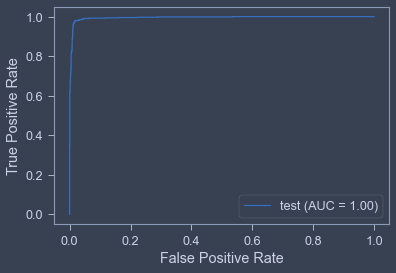

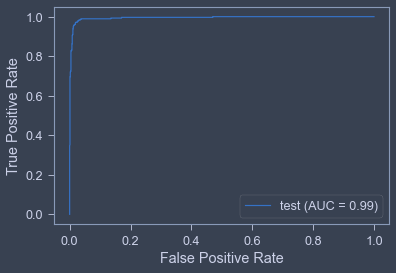

In [29]:
estate_model = Real_estate_estimator(num_hidden_1 = 50, num_hidden_2 = 30).to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
estate_criterion = nn.BCEWithLogitsLoss(pos_weight=(len(train_targets)-sum(train_targets))/sum(train_targets))
estate_optimizer = optim.Adam(estate_model.parameters(), lr=0.001, weight_decay=0.0005)
iters = []
losses = []
train_acc = []
val_acc = []
for n in range(150):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        estate_model.train() 
        out = estate_model(x, cat_x).squeeze()           

        loss = estate_criterion(out, labels)
        loss.backward()  
        epoch_losses.append(loss.item())
        estate_optimizer.step()              
        estate_optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(estate_model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(estate_model, train_loader)) # compute training accuracy
    val_acc.append(test_acc)  # compute validation accuracy
        

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))
print("Final Training Roc: {}".format(get_roc(estate_model, train_loader)))
print("Final Validation Roc: {}".format(get_roc(estate_model, test_loader)))

+ Wykresy loss oraz dokładności:

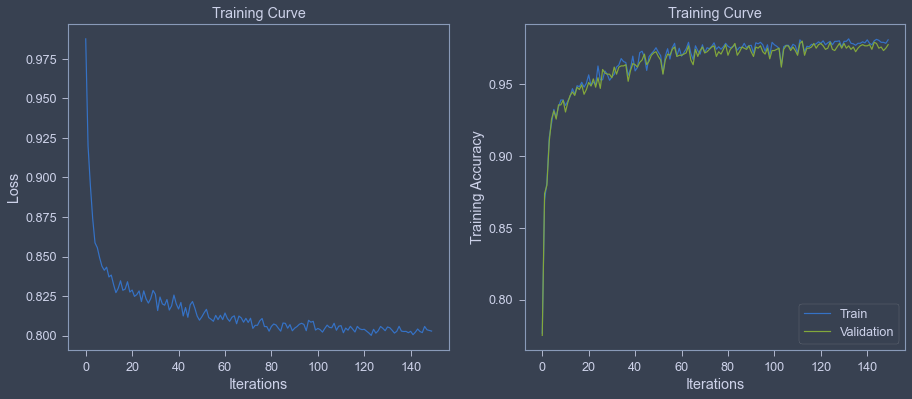

In [30]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')

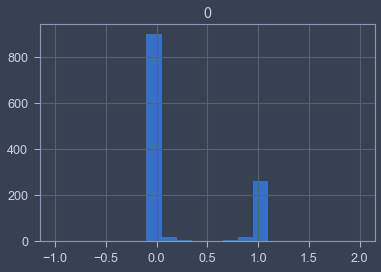

In [31]:
preds = estate_model(test_numerical_data.to(device),test_categorical_data.to(device))
pd.DataFrame(preds.cpu().detach().numpy()).hist(bins=20, range=(-1,2));

In [32]:
torch.set_printoptions(sci_mode=False)
preds

tensor([[    0.0001],
        [    0.0001],
        [    0.0003],
        ...,
        [    0.0000],
        [    1.0000],
        [    1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [33]:
test_targets

tensor([0., 0., 0.,  ..., 0., 1., 1.])

## Zapisanie do pliku:

In [34]:
eval_dataset = data.TensorDataset(torch.from_numpy(estate_data_eval.values).float(), torch.from_numpy(eval_categorical_values.values[:, :]).float())
next(iter(eval_dataset))

(tensor([-1.1227, -1.6060, -0.3535, -0.1202,  0.2656, -4.3172, -0.2567,  1.4956,
         -0.0889, -0.5401,  1.5096,  0.8490,  0.5220,  1.1330,  1.0473,  1.4649,
         -1.1200,  0.1326,  1.3945, -0.9960,  1.0433,  0.5560,  1.5098,  1.5058,
         -0.7698,  1.2074,  1.3898]),
 tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]))

In [35]:
preds_list_eval = []
estate_model.eval()
with torch.no_grad():
    for x, x_cat in eval_dataset:
        x = x.to(device).unsqueeze(0)
        x_cat = x_cat.to(device).unsqueeze(0)
        preds_val = estate_model(x, x_cat)
        preds_val = preds_val.cpu()
        preds_list_eval.append((float(preds_val), int(float(preds_val)>0.5)))
df_out = pd.DataFrame(preds_list_eval)
df_out

,0,1
0,5.482598e-06,0
1,1.839457e-05,0
2,2.739181e-06,0
3,1.544009e-05,0
4,1.008078e-01,0
...,...,...
1762,9.519453e-05,0
1763,2.549593e-05,0
1764,6.357588e-07,0
1765,1.000000e+00,1


In [36]:
csv = df_out.to_csv(index=False, header=False)
with open('data/result.csv', 'w', newline="") as f:
    f.write(csv)